In [1]:
import os.path
import sys

import keras.metrics
from keras import callbacks, models, metrics
from datahandler.constants import all_features, data_version, acc_features, tensorboard_dir, location_labels
from datahandler.data_preprocessing import get_train_test_data, load_data_v3
from models.log_writer import LogWriter
from model.lstm import make_lstm_model_v1
from model.transformer import make_transformer_model_v1, make_transformer_model_v2
from model.cnn import make_cnn_model_v1, make_cnn_model_v2
import matplotlib.pyplot as plt
from utils import print_line_divider
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from datahandler.data_preprocessing_from_jupyter import load_train_test_data_raw_normalized,load_train_test_data_added_features_normalized, load_train_test_data_added_features_pca
from audio.audio import play_training_is_complete
from sklearn.metrics import classification_report
import time

In [18]:
# LOGGING CONFIGURATION
enabled_log = True
enabled_tensor_board = True
log_writer = LogWriter(enabled_log)

In [19]:
# TRAINING CONFIGURATION
print("STARTING THE TRAINING PROCESS")
SAVED_BEST_MODEL = "model/best_model.h5"
window_time_in_seconds = 2
window_size = 40
epochs = 100
batch_size = 32
validation_split = 1 / 9
optimizer = 'adam'
loss_function = "sparse_categorical_crossentropy"
supported_features = all_features

STARTING THE TRAINING PROCESS


In [20]:
log_writer.write("Configuration", line_divider=True)
log_writer.write(
    f"""Window size: {window_size}
Window time in second: {window_time_in_seconds}
Maximum number of epochs: {epochs}
Batch size: {batch_size}
Validation split: {validation_split}
Optimizer: {optimizer}
Loss function: {loss_function}"""
)

In [5]:
# DATA Loader
print_line_divider()
print("Preparing data...")
# x_train, y_train, x_test, y_test = get_train_test_data(supported_features, window_time_in_seconds, window_size)
# x_train, y_train, x_test, y_test = load_data_v3(
#     features = supported_features,
#     window_time_in_seconds = window_time_in_seconds,
#     window_size = window_size
# )
x_train, y_train, x_test, y_test = load_train_test_data_raw_normalized()
print("Train data shape: " + str(x_train.shape) + " | Train label shape: " + str(y_train.shape))
print("Test data shape: " + str(x_test.shape) + " | Test label shape: " + str(y_test.shape))
print_line_divider()


****************************************************
Preparing data...
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/train/px4_datacollection.csv (1/74)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/train/mm5_datacollection.csv (2/74)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/train/ps1_datacollection.csv (3/74)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/train/px15_datacollection.csv (4/74)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/train/sx11_datacollection.csv (5/74)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/train/ht13_datacollection.csv (6/74)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/train/hc11_datacollection.csv (7/74)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/conte

In [21]:
log_writer.write("Data", line_divider=True)
log_writer.write("Data loaded from version " + data_version)
log_writer.write(
    f"""Data training shape: ${x_train.shape}
Data testing shape: ${x_test.shape}"""
)

In [22]:
def check_distribution(labels_list, set_name):
    label_count_dict = {}
    for label_ind in labels_list:
        if label_ind in label_count_dict.keys():
            label_count_dict[label_ind] += 1
        else:
            label_count_dict[label_ind] = 1

    print_line_divider()
    print("Distribution for set " + set_name + "\n")
    for key in label_count_dict:
        key = int(key)
        print(location_labels[key] + " count is " + str(label_count_dict[key]))


check_distribution(y_train, "Training set")
check_distribution(y_test, "Testing set")

****************************************************
Distribution for set Training set

insidethepantpocket count is 3359
holdinginhand count is 3644
beingusedinhand count is 3636
insidethebag count is 3597
calling count is 3619
****************************************************
Distribution for set Testing set

insidethepantpocket count is 833
holdinginhand count is 855
beingusedinhand count is 863
insidethebag count is 912
calling count is 882


In [23]:
if len(x_train.shape) == 2:
    input_shape = (x_train.shape[1], 1)
else:
    input_shape = x_train.shape[1:]
print("Input shape: " + str(input_shape))

Input shape: (40, 9)


In [24]:
# SETTING UP THE MODEL
# input_shape = x_train.shape[1:] # (window_size, len(supported_features))
# model_name, model = make_cnn_model_v1(input_shape=input_shape)
# model_name, model = make_lstm_model_v1(input_shape=input_shape)
model_name, model = make_transformer_model_v1(
    input_shape=input_shape,
    head_size=64,
    num_heads=6,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
# model_name, model = make_transformer_model_v2(input_shape=input_shape)
print("Model Summary:")
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)
print(print_line_divider())

Model Summary:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40, 9)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 40, 9)       18          ['input_4[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 40, 9)       14985       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                             

In [25]:
# LOGGING THE MODEL
log_writer.write("Model", line_divider=True)
log_writer.write("Model name: " + model_name)
log_writer.write(short_model_summary)

In [26]:
# MODELS CALLBACK AND SETUP
callback_list = [
    callbacks.ModelCheckpoint(SAVED_BEST_MODEL, save_best_only=True, monitor="val_loss"),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=25, min_lr=0.0001),
    callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)
]
if enabled_tensor_board:
    callback_list.append(callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1))
if log_writer.enabled:
    callback_list.append(
        callbacks.ModelCheckpoint(log_writer.base_folder + "/model.h5", save_best_only=True, monitor="val_loss")
    )
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=["sparse_categorical_accuracy"],
)

In [27]:
# TRAINING
print_line_divider()
print("Starting to train...")

start_time = time.time()
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_split=validation_split,
    verbose=1,
    shuffle=True
)
end_time = time.time()
training_time = end_time - start_time
print("Total training time in seconds: " + str(training_time))
print("Highest validation accuracy: ", max(history.history['val_sparse_categorical_accuracy']))
log_writer.write("Result", line_divider=True)
log_writer.write("Training time: " + str(end_time - start_time) + " seconds.")
log_writer.write("Highest validation accuracy: " + str(max(history.history['val_sparse_categorical_accuracy'])))
play_training_is_complete()

****************************************************
Starting to train...
Epoch 1/100
496/496 [==============================] - 37s 71ms/step - loss: 1.3219 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.4839 - val_sparse_categorical_accuracy: 0.3967 - lr: 0.0010
Epoch 2/100
496/496 [==============================] - 39s 80ms/step - loss: 0.9938 - sparse_categorical_accuracy: 0.5616 - val_loss: 1.5020 - val_sparse_categorical_accuracy: 0.5776 - lr: 0.0010
Epoch 3/100
496/496 [==============================] - 39s 78ms/step - loss: 0.7858 - sparse_categorical_accuracy: 0.6908 - val_loss: 1.7881 - val_sparse_categorical_accuracy: 0.5645 - lr: 0.0010
Epoch 4/100
496/496 [==============================] - 42s 85ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.7415 - val_loss: 1.5614 - val_sparse_categorical_accuracy: 0.5872 - lr: 0.0010
Epoch 5/100
496/496 [==============================] - 42s 85ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7742 - val_loss: 1.8428 -

Input #0, wav, from '/var/folders/ph/8yv0q18n4mb1439tnf3rzcf40000gp/T/tmpk90qqerl.wav':
  Duration: 00:00:02.27, bitrate: 705 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s16, 705 kb/s


In [28]:
if log_writer.enabled:
    model.save(log_writer.base_folder + "/model_last.h5")

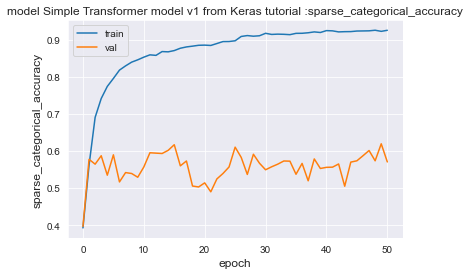

In [29]:
# PLOTTING
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + model_name + " :" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Validation progress.png"))
plt.show()
plt.close()

136/136 [==============================] - 6s 42ms/step - loss: 1.2296 - sparse_categorical_accuracy: 0.4104
****************************************************
Test accuracy 0.410356730222702
Test loss 1.2295557260513306
Metrics report: 
              precision    recall  f1-score   support

         0.0       0.47      0.19      0.28       855
         1.0       0.39      0.63      0.48       912
         2.0       0.27      0.11      0.16       882
         3.0       0.48      0.87      0.62       833
         4.0       0.34      0.25      0.29       863

    accuracy                           0.41      4345
   macro avg       0.39      0.41      0.37      4345
weighted avg       0.39      0.41      0.36      4345



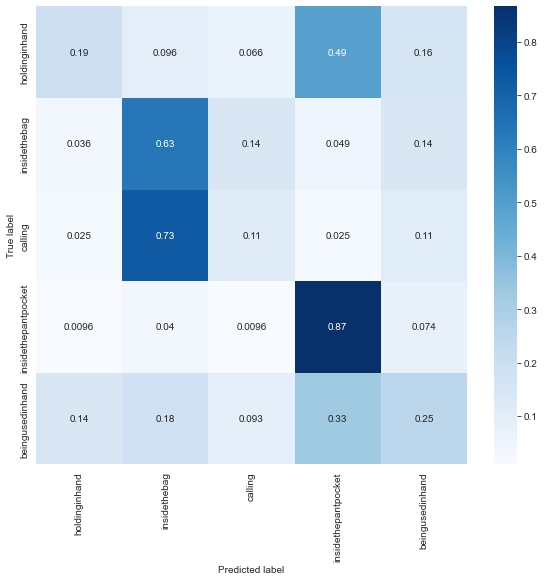

In [30]:
# EVALUATION
model = models.load_model(SAVED_BEST_MODEL)
test_loss, test_acc = model.evaluate(x_test, y_test)
print_line_divider()
print("Test accuracy", test_acc)
print("Test loss", test_loss)

# Accuracy based on different labels
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
metrics_report = classification_report(y_test, y_pred)
print("Metrics report: ")
print(metrics_report)

con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)
con_mat_df = pd.DataFrame(con_mat_norm, index=location_labels, columns=location_labels)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Accuracy.png"))
plt.show()
plt.close()

log_writer.write("Test evaluation", line_divider=True)
log_writer.write("Test accuracy: " + str(test_acc))
log_writer.write("Test loss: " + str(test_loss))
log_writer.write("Metric report: ")
log_writer.write(metrics_report)
log_writer.close()